

Реализуем класс стохастических бандитов с бернулиевским распределением выигрышей. 


In [20]:
import numpy as np

In [146]:
class BernoulliBandit:
  #принимает на вход список из K>=2 чисел из [0,1]
    def __init__(self, means):
        self.means = np.array(means)
        self.T = 0
        self.realization = np.array([])
        self.best_realization = np.array([])
        self.best_mean = max(self.means)
  
  #Функция возвращает число ручек
    def K(self):
        return len(self.means)

  #Принимает параметр 0 <= a <= K-1 и возвращает реализацию случайной величины 
  #X c P[X=1] равной среднему значению выигрыша ручки a+1
    def pull(self, a):
        self.T += 1
        xi = np.random.binomial(1, self.means[a])
        xi_best = np.random.binomial(1, self.best_mean)
        self.realization = np.append(self.realization, xi)
        self.best_realization = np.append(self.best_realization, xi_best)
        return xi        

  #Возвращает текущее значение регрета
    def regret(self):
        return sum(self.best_realization) - sum(self.realization)

In [116]:
bandit = BernoulliBandit([0.2, 0.3, 0.7, 0.1])
bandit.pull(3)
bandit.pull(0)
bandit.pull(1)
bandit.pull(2)
bandit.pull(0)
bandit.pull(0)
bandit.pull(1)
print(bandit.realization)
print(bandit.best_realization)
print(bandit.regret())

[0. 0. 0. 1. 0. 1. 0.]
[1. 1. 1. 0. 0. 0. 1.]
2.0




Алгоритм "Следуй за лидером": 


1.   Сыграть каждое действие 1 раз
2.   Играть действие (ручку) с максимальным на данный момент средним выигрышем 

P.S. То есть сначала мы играем каждую ручку. Полученые выигрыши - стартовое приближение для среднего выигрыша.

Реализуем алгоритм "Следуй за лидером"



In [190]:
def FollowTheLeader(bandit, T):
    temp = np.zeros((bandit.K(), 3))
    for i in range(bandit.K()):
        bandit.pull(i)
        temp[i, 0] = bandit.realization[-1]
        temp[i, 1] = temp[i, 0]
        temp[i, 2] = 1
    for i in range(T - bandit.K()):
        idx = temp.argmax(axis=0)[1]
        bandit.pull(idx)
        temp[idx, 0] += bandit.realization[-1]
        temp[idx, 2] += 1
        temp[idx, 1] = temp[idx, 0]/temp[idx, 2]
    return bandit.regret()

Реализуем алгоритм Explore-First

In [311]:
def ExploreFirst(bandit, T, k):
    temp = np.zeros((bandit.K(), 3))
    for j in range(k):
        for i in range(bandit.K()):
            bandit.pull(i)
            temp[i, 0] += bandit.realization[-1]
            temp[i, 2] += 1
            temp[i, 1] = temp[i, 0]/temp[i, 2]
    idx = temp.argmax(axis=0)[1]
    for i in range(T - k*bandit.K()):
        bandit.pull(idx)
    return bandit.regret()


Реализуем алгоритм $\varepsilon$-Greedy

In [239]:
def EGreedy(bandit, T, e):
    temp = np.zeros((bandit.K(), 3))
    bandit_len = bandit.K()
    for i in range(T):
        if np.random.binomial(1, e) == 1:
            xi = np.random.randint(0, bandit_len)
            bandit.pull(xi)
            temp[xi, 0] += bandit.realization[-1]
            temp[xi, 2] += 1
            temp[xi, 1] = temp[xi, 0]/temp[xi, 2]
        else:
            idx = idx = temp.argmax(axis=0)[1]
            bandit.pull(idx)
            temp[idx, 0] += bandit.realization[-1]
            temp[idx, 2] += 1
            temp[idx, 1] = temp[idx, 0]/temp[idx, 2]
    return bandit.regret()

Реализуем алгоритм Successive Elimination

In [138]:
import math as m

In [357]:
def SuccessiveElimination(bandit, T):
    temp_set = {i for i in range(bandit.K())}
    temp = np.zeros((bandit.K(), 5))
    rounds = 0
    while len(temp_set) > 1:
        for i in temp_set:
            rounds += 1
            bandit.pull(i)
            temp[i, 0] += bandit.realization[-1]
            temp[i, 1] += 1
            temp[i, 2] = temp[i, 0]/temp[i, 1]
            temp[i, 3] = temp[i, 2] - 0.1*m.sqrt(2*m.log10(T)/temp[i, 1])
            temp[i, 4] = temp[i, 2] + 0.1*m.sqrt(2*m.log10(T)/temp[i, 1])
        max_av = np.max(temp, axis=0)[3]
        rem_set = set()
        for i in temp_set:
            if temp[i][4] < max_av:
                rem_set.add(i)
        for i in rem_set:
            temp_set.remove(i)
    idx = list(temp_set)[0]
    for i in range(T - rounds):
        bandit.pull(idx)
    return bandit.regret()


Реализуем алгоритм UCB1

In [254]:
def UCB(bandit, T):
    temp = np.zeros((bandit.K(), 4))
    for i in range(bandit.K()):
        bandit.pull(i)
        temp[i, 0] += bandit.realization[-1]
        temp[i, 1] += 1
        temp[i, 2] = temp[i, 0]/temp[i, 1]
        temp[i, 3] = temp[i, 2] + 0.9*m.sqrt(2*m.log10(T)/temp[i, 1])
    for i in range(T - bandit.K()):
        idx = np.argmax(temp, axis=0)[3]
        bandit.pull(idx)
        temp[idx, 0] += bandit.realization[-1]
        temp[idx, 1] += 1
        temp[idx, 2] = temp[idx, 0]/temp[idx, 1]
        temp[idx, 3] = temp[idx, 2] + 0.9*m.sqrt(2*m.log10(T)/temp[idx, 1])
    return bandit.regret()

Протестируем алгоритмы, реализованные выше для бандита из класса бернулли):


1.   2 ручки ($\mu_1=0.5$, $\mu_2=0.6$), $T \in \{100, 200, \dots, 1000\}$,  Проведем 1000 симуляций.
2.   10 ручек $(\mu_1 = 0.4, \dots, \mu_{10}=0.85)$, $T \in \{100, 200, \dots, 1000\}$,  Проведем 1000 симуляций.
3.   Построим график среднего регрета как функцию от $T$. Оценим качество алгоритмов.



In [323]:
T_space = list(map(int, np.linspace(3000, 3600, 7)))
res = np.zeros((6, 7))

In [300]:
from tqdm import tqdm

In [324]:
for i in tqdm(range(7)):
    for j in range(100):
        bandit = BernoulliBandit([0.5, 0.6])
        res[0, i] += FollowTheLeader(bandit, T_space[i])
        bandit = BernoulliBandit([0.5, 0.6])
        res[1, i] += ExploreFirst(bandit, T_space[i], 100)
        bandit = BernoulliBandit([0.5, 0.6])
        res[2, i] += EGreedy(bandit, T_space[i], 0.3)
        bandit = BernoulliBandit([0.5, 0.6])
        res[3, i] += SuccessiveElimination(bandit, T_space[i])
        bandit = BernoulliBandit([0.5, 0.6])
        res[4, i] += UCB(bandit, T_space[i])
        bandit = BernoulliBandit([0.5, 0.6])
        res[5, i] += RandomAlg(bandit, T_space[i])
res /= 100

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [08:47<00:00, 78.13s/it]


In [330]:
res

array([[146.52, 167.86, 153.41, 187.38, 184.75, 189.16, 174.39],
       [ 30.48,  21.71,  29.28,  36.5 ,  47.41,  30.76,  25.84],
       [ 48.08,  52.56,  54.64,  50.95,  59.11,  55.66,  59.31],
       [217.53, 225.13, 208.54, 219.98, 215.36, 227.66, 212.03],
       [ 25.62,  19.9 ,  28.93,  21.7 ,  22.69,  32.07,  29.  ],
       [143.46, 153.  , 160.59, 164.48, 168.53, 175.49, 181.38]])

In [342]:
def RandomAlg(bandit, T):
    bandit_len = bandit.K()
    for i in range(T):
        bandit.pull(np.random.randint(0, bandit_len))
    return bandit.regret()

In [343]:
res2 = np.zeros((6, 7))

In [344]:
mu = list(np.linspace(0.4, 0.85, 10))

In [345]:
for i in tqdm(range(7)):
    for j in range(500):
        bandit = BernoulliBandit(mu)
        res2[0, i] += FollowTheLeader(bandit, T_space[i])
        bandit = BernoulliBandit(mu)
        res2[1, i] += ExploreFirst(bandit, T_space[i], 100)
        bandit = BernoulliBandit(mu)
        res2[2, i] += EGreedy(bandit, T_space[i], 0.3)
        bandit = BernoulliBandit(mu)
        res2[3, i] += SuccessiveElimination(bandit, T_space[i])
        bandit = BernoulliBandit(mu)
        res2[4, i] += UCB(bandit, T_space[i])
        bandit = BernoulliBandit(mu)
        res2[5, i] += RandomAlg(bandit, T_space[i])
res2 /= 500


100%|█████████████████████████████████████████████████████████████████████████████████| 7/7 [1:15:52<00:00, 656.97s/it]

In [346]:
res2

array([[ 137.278,  135.31 ,  149.142,  137.632,  153.272,  153.566,
         168.532],
       [ 249.26 ,  250.562,  253.16 ,  260.956,  257.344,  258.672,
         259.542],
       [ 230.052,  237.25 ,  242.522,  248.026,  256.48 ,  262.782,
         272.088],
       [1251.832, 1262.658, 1278.984, 1280.662, 1289.648, 1286.152,
        1275.168],
       [ 146.526,  149.506,  149.42 ,  154.188,  154.178,  155.718,
         156.882],
       [ 673.266,  698.44 ,  717.616,  743.428,  764.074,  784.148,
         806.882]])

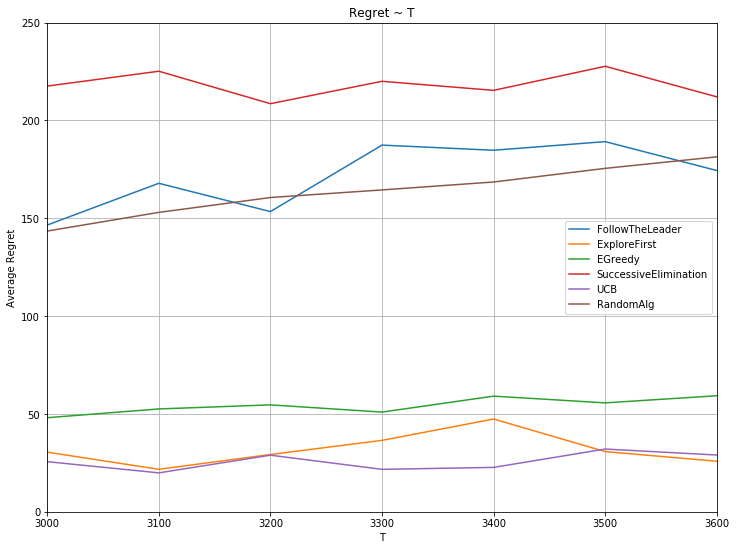

In [341]:
import matplotlib.pyplot as plt

# Plot all ROC curves
plt.figure(figsize=(12, 9))


labels = ['FollowTheLeader', 'ExploreFirst', 'EGreedy', 'SuccessiveElimination', 'UCB', 'RandomAlg']
for i in range(6):
    plt.plot(T_space, res[i], label=labels[i])


plt.xlim([3000., 3600.])
plt.ylim([0.0, 250.])
plt.xlabel('T')
plt.ylabel('Average Regret')
plt.title('Regret ~ T, $\mu_1 = 0.5, \mu_2 = 0.6$')
plt.legend()
plt.grid(True)
plt.show()


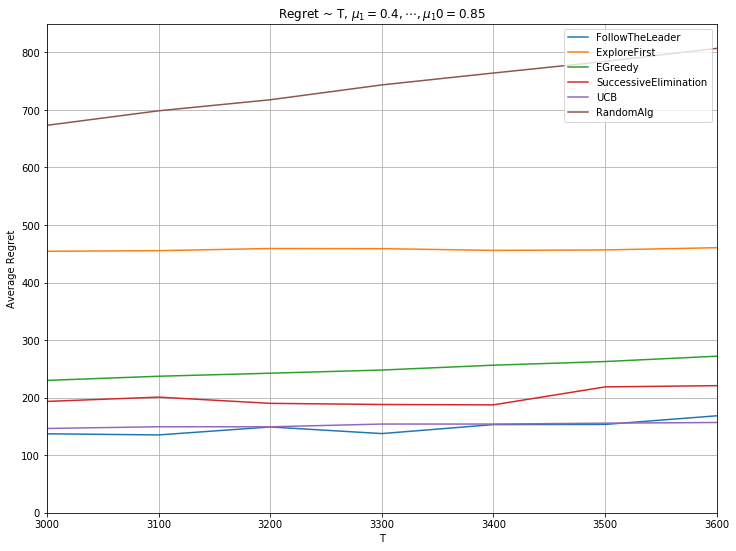

In [364]:
import matplotlib.pyplot as plt

# Plot all ROC curves
plt.figure(figsize=(12, 9))


labels = ['FollowTheLeader', 'ExploreFirst', 'EGreedy', 'SuccessiveElimination', 'UCB', 'RandomAlg']
for i in range(6):
    plt.plot(T_space, res2[i], label=labels[i])


plt.xlim([3000., 3600.])
plt.ylim([0.0, 850.])
plt.xlabel('T')
plt.ylabel('Average Regret')
plt.title('Regret ~ T, $\mu_1 = 0.4,\cdots, \mu_10 = 0.85$')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
res[1:4:2] = 0

In [362]:
for i in tqdm(range(7)): #добавил в 6 алгоритме умножение радиуса на константу, результаты стали лучше.
    for j in range(500):
        res2[1, i] += ExploreFirst(bandit, T_space[i], 200)
        bandit = BernoulliBandit(mu)
        res2[3, i] += SuccessiveElimination(bandit, T_space[i])
        bandit = BernoulliBandit(mu)
res2[1:4:2] /= 500



  0%|                                                                                            | 0/7 [00:00<?, ?it/s]

 14%|████████████                                                                        | 1/7 [01:11<07:07, 71.32s/it]

 29%|████████████████████████                                                            | 2/7 [02:26<06:02, 72.54s/it]

 43%|████████████████████████████████████                                                | 3/7 [03:41<04:52, 73.11s/it]

 57%|████████████████████████████████████████████████                                    | 4/7 [04:59<03:44, 74.75s/it]

 71%|████████████████████████████████████████████████████████████                        | 5/7 [06:17<02:31, 75.74s/it]

 86%|████████████████████████████████████████████████████████████████████████            | 6/7 [07:40<01:17, 77.85s/it]

100%|████████████████████████████████████████████████████████████████████████████████████| 7/7 [09:08<00:00, 80.84s/it]

In [363]:
res2

array([[137.278, 135.31 , 149.142, 137.632, 153.272, 153.566, 168.532],
       [454.396, 455.426, 459.2  , 458.934, 455.922, 456.702, 460.57 ],
       [230.052, 237.25 , 242.522, 248.026, 256.48 , 262.782, 272.088],
       [193.53 , 200.976, 190.154, 188.196, 187.556, 218.742, 220.892],
       [146.526, 149.506, 149.42 , 154.188, 154.178, 155.718, 156.882],
       [673.266, 698.44 , 717.616, 743.428, 764.074, 784.148, 806.882]])

В обоих примерах лучше всего работает алгоритм $UCB$, как и ожидалось. Увидел странности алгоритма $SuccessiveElimination$, в нем похоже нужно домножать радиус на что-то маленькое, так как если этого не делать, возможно, он не успевает нормально обучиться и отбросить плохие ручки, сначала я запустил этот алгоритм без домножения на константу, получилось, что он отрабатывает хуже чем рандомный алгоритм(когда на каждом раунде мы рандомно выбираем ручку), после домножения во втором примере, он отработал немного хуже, чем $UCB$. Также, странно, что во втором примере хорошо отработал первый алгоритм, на бандите с двумя ручками он показал плохой результат, если честно, не понял, с чем это связано. Алгоритмы $\varepsilon-Greedy$ и $Explore First$ очень чувтсвительны к настройке, если в первом алгоритме давать маленькую вероятность для фазы exploration, он работает очень плохо, ровно как и если давать большую вероятность, во втором алгоритме также -- при маленьких $k$ не успевает найти хорошую ручку, при больших -- слишком часто ошибается в начале, поэтому здесь необходима подборка коэффициентов.